In [ ]:
# default_exp modeling.seq2seq.language_modeling

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.seq2seq.language_modeling

> This module contains custom models, custom splitters, etc... for both causal and MLM language modeling tasks. This includes things like training BERT from scratch or fine-tuning a particular pre-trained LM on your own corpus.

**This is currently a work in progress** - You've been warned : )

In [ ]:
#export
import ast

import torch
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import *
from blurr.data.seq2seq.core import *
from blurr.data.seq2seq.language_modeling import *
from blurr.modeling.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Causal Language Modeling

In causal language modeling, we are attempting to predict the next token given those before it.

In [ ]:
wiki_path = untar_data(URLs.WIKITEXT_TINY)

train_df = pd.read_csv(wiki_path/'train.csv', header=None)
valid_df = pd.read_csv(wiki_path/'test.csv', header=None)

train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])

print(len(df))
df.head()

662


,0,is_valid
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z...",False
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re...",False
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit...",False
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch...",False
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ....",False


In [ ]:
task = HF_TASKS_AUTO.CausalLM

pretrained_model_name = "gpt2"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, task=task)

if (hf_tokenizer.pad_token is None): hf_tokenizer.pad_token = '[PAD]'

Using pad_token, but it is not set yet.


In [ ]:
blocks = (
    HF_Seq2SeqBlock(before_batch_tfm=HF_CausalLMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model)), 
    noop
)

dblock = DataBlock(blocks=blocks, get_x=ColReader(0), splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[0]['labels'].shape, b[1].shape

(torch.Size([2, 1024]), torch.Size([2, 1024]), torch.Size([2, 1024]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=500, target_trunc_at=500)

,text,target
0,"\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They A","\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They A"
1,"\n = Wales national rugby union team = \n \n The Wales national rugby union team ( Welsh : <unk> <unk> <unk> <unk> <unk> Cymru ) represent Wales in international rugby union. They compete annually in the Six Nations Championship with England, France, Ireland, Italy and Scotland. Wales have won the Six Nations and its predecessors 26 times outright, one less than England. Wales'most recent championship win came in 2013. \n The governing body, the Welsh Rugby Union ( WRU ), was established in 1881, t","\n = Wales national rugby union team = \n \n The Wales national rugby union team ( Welsh : <unk> <unk> <unk> <unk> <unk> Cymru ) represent Wales in international rugby union. They compete annually in the Six Nations Championship with England, France, Ireland, Italy and Scotland. Wales have won the Six Nations and its predecessors 26 times outright, one less than England. Wales'most recent championship win came in 2013. \n The governing body, the Welsh Rugby Union ( WRU ), was established in 1881, t"


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)#.to_fp16()

learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.blurr_summary()

In [ ]:
# b = dls.one_batch()
# preds = learn.model(b[0])
# len(preds),preds[0], preds[1].shape

In [ ]:
print(len(learn.opt.param_groups))

5


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=6.309573450380412e-07)

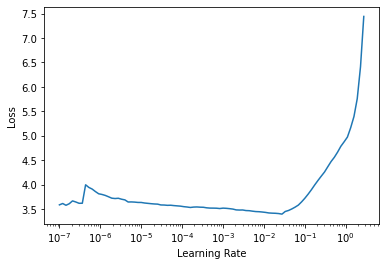

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,3.045245,2.810324,01:38


## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-seq2seq-core.ipynb.
Converted 01zb_data-seq2seq-language-modeling.ipynb.
Converted 01zc_data-seq2seq-summarization.ipynb.
Converted 01zd_data-seq2seq-translation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-seq2seq-core.ipynb.
Converted 02zb_modeling-seq2seq-language-modeling.ipynb.
Converted 02zc_modeling-seq2seq-summarization.ipynb.
Converted 02zc_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
